# SINDy example code

In [1]:
import numpy as np
from scipy.integrate import odeint
from sklearn.model_selection import KFold, GridSearchCV

from context import sindy
from sindy import SINDy
from sindy.differentiation import differentiation_methods
from sindy.optimizers import STLSQ, SR3

import matplotlib.pyplot as plt
%matplotlib inline

## Generate training data

### harmonic oscillator

In [ ]:
def rhs_harmonic_oscillator(y, t):
    dy0 = y[1]
    dy1 = -0.3 * y[0]
    return [dy0, dy1]

In [ ]:
n_points = 1000

x0 = [0, 1]
t = np.linspace(0, 10, n_points)
x = odeint(rhs_harmonic_oscillator, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

### lorenz

In [2]:
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

In [3]:
n_points = 1000

x0 = [8,27,-7]
t = np.linspace(0, 10, n_points)
x = odeint(lorenz, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

## Basic examples

### Simplest version

In [4]:
model = SINDy()
model.fit(x_train, t_train)

SINDy(differentiation_method=<function centered_difference at 0x1a15ce8b90>,
      feature_library=PolynomialFeatures(degree=2, include_bias=True,
                                         interaction_only=False, order='C'),
      feature_names=None, n_jobs=1,
      optimizer=STLSQ(copy_X=True, fit_intercept=False, max_iter=100,
                      normalize=False, threshold=0.1,
                      threshold_intercept=False))

In [5]:
print(model.equations())

['-9.961 x0 + 9.961 x1', '27.559 x0 + -0.922 x1 + -0.988 x0 x2', '-2.648 x2 + 0.993 x0 x1']


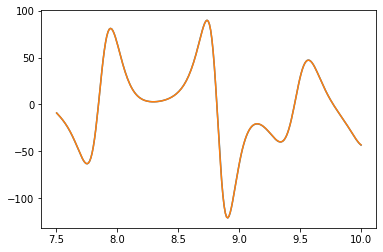

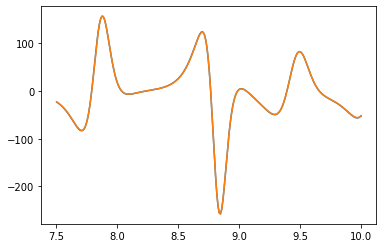

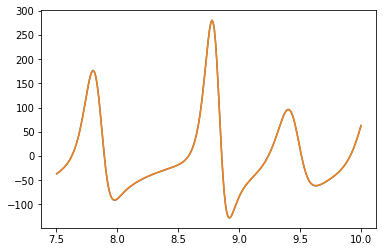

In [6]:
for i in range(x_test.shape[1]):
    plt.figure()
    plt.plot(t_test, differentiation_methods.centered_difference(x_test, t_test)[:,i])
    plt.plot(t_test, model.predict(x_test)[:,i])

## Change some options

In [7]:
from sindy.optimizers import STLSQ, SR3
from sklearn.preprocessing import PolynomialFeatures

In [11]:
model = SINDy(optimizer=SR3())
model.fit(x_train, t_train)

SINDy(differentiation_method=<function centered_difference at 0x1a15ce8b90>,
      feature_library=PolynomialFeatures(degree=2, include_bias=True,
                                         interaction_only=False, order='C'),
      feature_names=None, n_jobs=1,
      optimizer=SR3(copy_X=True, fit_intercept=False, max_iter=100,
                    normalize=False, nu=1.0, threshold=0.1,
                    threshold_intercept=False))

In [12]:
print(model.equations())

['-0.279  + -10.112 x0 + 10.080 x1', '1.419  + 27.555 x0 + -0.851 x1 + -0.139 x2 + -0.987 x0 x2', '-0.245 x0 + 0.250 x1 + -2.593 x2 + 0.985 x0 x1']


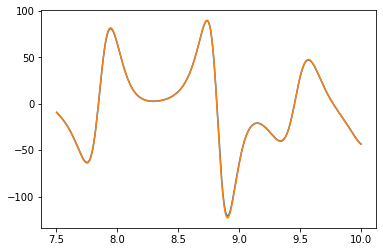

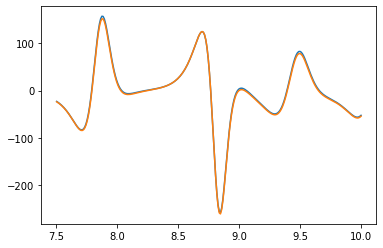

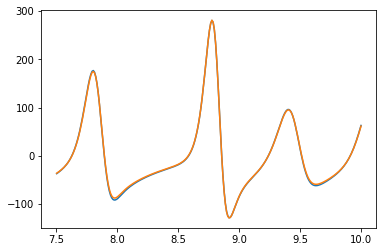

In [13]:
for i in range(x_test.shape[1]):
    plt.figure()
    plt.plot(t_test, differentiation_methods.centered_difference(x_test, t_test)[:,i])
    plt.plot(t_test, model.predict(x_test)[:,i])